# Restaurant Recommender System based on LightGCN

## 1. Install Packages and Libraries

In [1]:
# Install required packages.
%%capture
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
# import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch.nn.functional as F
from torch import Tensor, nn, optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import negative_sampling, structured_negative_sampling
from torch_sparse import SparseTensor, matmul

## 2. Data Loading and Preprocessing

Google Restaurants Dataset (the filtered subset ~112M)

We read the json file, and transform the data into tensor node embeddings that are suitable for model training

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving filter_all_t.json to filter_all_t.json


In [3]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal_restaurants/filter_all_t.json -O filter_all_t.json

--2024-12-08 08:57:34--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal_restaurants/filter_all_t.json
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117893558 (112M) [application/json]
Saving to: ‘filter_all_t.json’

filter_all_t.json   100%[===================>] 112.43M  32.7MB/s    in 3.7s    

2024-12-08 08:57:38 (30.4 MB/s) - ‘filter_all_t.json’ saved [117893558/117893558]



In [4]:
import json

# Load JSON file
with open('filter_all_t.json', 'r') as file:
    data = json.load(file)

In [5]:
# The dataset contains train, val, and test sets.
train_data = pd.DataFrame(data["train"])
val_data = pd.DataFrame(data["val"])
test_data = pd.DataFrame(data["test"])

print("The dim of training data:", train_data.shape)
print("The dim of validation data:", val_data.shape)
print("The dim of test data:", test_data.shape)

The dim of training data: (87013, 6)
The dim of validation data: (10860, 6)
The dim of test data: (11015, 6)


In [6]:
train_data.head()

,business_id,user_id,rating,review_text,pics,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,"[AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0,...",[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[AF1QipMpfxIZUT_aymQ3qPGO-QgGYzxbtLZGmHufAp2s],[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,"[AF1QipMNnqM5X9sSyZ9pXRZ1jvrURHN9bZhGdzuEXoP8,...",[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,"[AF1QipM-a6AGGp4Hgk5RD0gY5sDRp5kEfB1hZLvlRkft,...",[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[AF1QipNVys4yq-5w_3EsDdHpSc9ZNb7Nl30Mfb6Y0Gup],[[109802745326785766951_60524fa9f09a4ffff042f9...


In [6]:
def preprocessing(data):
  '''
  Args:
    data (pd.DataFrame)
  Returns:
    data (pd.DataFrame)
    user_id_map (dict)
    business_id_map (dict)
  '''
  # Create a dictionary mapping user_id to consecutive values [0,..., n]
  user_id_map = {idx: i for i, idx in enumerate(data["user_id"].unique())}
  # Create a dictionary mapping business_id to consecutive values [0,..., m]
  business_id_map = {idx: i for i, idx in enumerate(data["business_id"].unique())}

  # Extend the dataframe with new ids
  data["u_id"] = data["user_id"].map(user_id_map)
  data["b_id"] = data["business_id"].map(business_id_map)
  data["r_id"] = data.index

  return data, user_id_map, business_id_map

In [7]:
train_data, train_user_id_map, train_business_id_map = preprocessing(train_data)
val_data, val_user_id_map, val_business_id_map = preprocessing(val_data)
test_data, test_user_id_map, test_business_id_map = preprocessing(test_data)

all_data = pd.concat([train_data, val_data, test_data])
all_data, all_user_id_map, all_business_id_map = preprocessing(all_data)

train_num_users, train_num_businesses = len(train_user_id_map), len(train_business_id_map)
val_num_users, val_num_businesses = len(val_user_id_map), len(val_business_id_map)
test_num_users, test_num_businesses = len(test_user_id_map), len(test_business_id_map)
num_users, num_businesses = len(all_user_id_map), len(all_business_id_map)

print("=============== Training Data ===============")
print("The number of users in training data: ", train_num_users)
print("The number of businesses in training data: ", train_num_businesses)
print("=============== Validation Data ===============")
print("The number of users in validation data: ", val_num_users)
print("The number of businesses in validation data: ", val_num_businesses)
print("=============== Test Data ===============")
print("The number of users in test data: ", test_num_users)
print("The number of businesses in test data: ", test_num_businesses)
print("=============== All Data ===============")
print("The number of users in all data: ", num_users)
print("The number of businesses in training data: ", num_businesses)


=============== Training Data ===============
The number of users in training data:  29596
The number of businesses in training data:  27896
=============== Validation Data ===============
The number of users in validation data:  3700
The number of businesses in validation data:  7835
=============== Test Data ===============
The number of users in test data:  3700
The number of businesses in test data:  7880
=============== All Data ===============
The number of users in all data:  36996
The number of businesses in training data:  30831


In [8]:
def generate_edge_index(data, user_id_map, business_id_map):
  '''
  Args:
    data              (pd.DataFrame)
    user_id_map       (dict)
    business_id_map   (dict)
  Returns:
    edge_index        (torch.tensor)
    edge_index_sparse (SparseTensor)
  '''
  ##############################################################################
  # Generate edge_index and edge_index_sparse (adjacency matrix)
  # For now, we assume there is only one edge type between user and business, i.e. review (interaction)
  # TODO: segregate reviews into different groups based on review text sentiment and/or rating (positive/neutral/negative)
  ##############################################################################
  edge_index = [[],[]] # dim = 2 x (# of reviews)
  for i in range(len(data)):
    edge_index[0].append(user_id_map[data["user_id"][i]])
    edge_index[1].append(business_id_map[data["business_id"][i]])
  edge_index = torch.tensor(edge_index)

  num_nodes = num_users + num_businesses
  edge_index_sparse = SparseTensor(
      row=torch.tensor(edge_index[0]),
      col=torch.tensor(edge_index[1]),
      sparse_sizes=(num_nodes, num_nodes))
  return edge_index, edge_index_sparse

In [9]:
# Generate a dictionary with key being user and value being positive items for the user
def get_user_positive_items(edge_index: Tensor):
    '''
    Args:
        edge_index (torch.Tensor): 2 by N list of edges
    Returns:
        user_pos_items (dict): dictionary of positive items for each user
    '''
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [23]:
def sample_negative_edges(edge_index, device=None):
  '''
  # Get all unique users
  users = torch.unique(edge_index[0])

  # Get all unique items
  items = torch.unique(edge_index[1])

  user_pos_items = get_user_positive_items(edge_index) # (dict)
  user_neg_items = {}
  for user in users:
    pos_items = user_pos_items[user.item()]
    neg_items = list(set(items) - set(pos_items))
    user_neg_items[user.item()] = neg_items

  random_neg_item = []
  for j in range(edge_index.shape[1]):
    user = edge_index[0][j].item()
    neg_item = random.choice(user_neg_items[user])
    random_neg_item = neg_item

  random_neg_item = torch.LongTensor(random_neg_item)
  edges = torch.stack((edge_index, random_neg_item), dim=0)
  return edges
  '''
  # Get all unique users
  num_users = len(torch.unique(edge_index[0]))

  # Get all unique items
  num_items = len(torch.unique(edge_index[1]))

  mask = torch.zeros(num_users, num_items, device=device, dtype=torch.bool)
  mask[edge_index[0], edge_index[1]] = True

  sampled_neg_edges = []
  for j in range(edge_index.shape[1]):
    user_id = edge_index[0][j].item()
    user_mask = mask[user_id]

    # Get the indices of items that the user has not interacted with (i.e., False in the mask)
    user_neg_items = torch.where(~user_mask)[0]
    sampled_user_neg_items = user_neg_items[torch.randint(0, len(user_neg_items), (1,), device=device)]
    sampled_neg_edges.append(sampled_user_neg_items.item())  # Append the sampled negative item

  sampled_neg_edges = torch.LongTensor(sampled_neg_edges).unsqueeze(0)
  sampled_neg_edges = sampled_neg_edges.to(edge_index.device)
  edges = torch.cat((edge_index, sampled_neg_edges), dim=0)
  return edges


In [10]:
def sample_mini_batch(batch_size, edge_index, device=None):
  edges = structured_negative_sampling(edge_index)
  # edges = sample_negative_edges(edge_index, device=device) # customized sampling
  # edges = negative_sampling(edge_index, num_nodes=(len(torch.unique(edge_index[0])), len(torch.unique(edge_index[1]))))
  # indices = torch.randperm(edges.shape[1])[:batch_size]
  indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
  # print(edges[0])
  # print("Indices", indices)
  batch = (edges[0][indices], edges[1][indices], edges[2][indices])
  user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
  return user_indices, pos_item_indices, neg_item_indices


## 3. LightGCN
*   Adjacency matrix of an undirected bipartite graph to indicate the existence of interaction between user and item.

*   Normalized adjacency matrix $\tilde{A}$ as $$\tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$$

*   Final node embedding matrix: $$E^{(K)} = \tilde{A}^{(K)} E W$$

*   Multi-scale diffusion: $$\alpha_0 E^{(0)} + \alpha_1 E^{(1)} + \cdots + \alpha_k E^{(K)}$$
and for simplicity, LightGCN uses the uniform coefficient, i.e., $$\alpha_k = \frac{1}{K+1} \quad \text{for} \quad k = 0, \dots, K$$


In [11]:
class LightGCNConv(MessagePassing):
  """ We adopt the LightGCN implementated in this tutorial:
  https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing#scrollTo=KqKI1VduKcwf
  """
  def __init__(self, num_users, num_items, embedding_dim, num_layers, add_self_loops=False):
    '''
    Args:
      num_users: number of users
      num_items: number of items
      embedding_dim: dimensionality of embeddings
      num_layers: number of message passing layers
      add_self_loops(optional): whether to add self
    '''
    super().__init__()
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers
    self.add_self_loops = add_self_loops

    # Substitute the initial embeddings here
    self.user_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
    self.item_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

    # Random normal initialization
    # (other options: uniform/normal Xavier initialization)
    nn.init.normal_(self.user_emb.weight, std=0.1)
    nn.init.normal_(self.item_emb.weight, std=0.1)

  def forward(self, edge_index: SparseTensor):
    # Compute normalized adjacency matrix
    A_tilde = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

    # Concat the embeddings of users and items
    emb_0 = torch.cat([self.user_emb.weight, self.item_emb.weight])
    embs = [emb_0]

    # Multi-scale diffusion
    emb_k = emb_0
    for k in range(self.num_layers):
      emb_k = self.propagate(A_tilde, x=emb_k)
      embs.append(emb_k)

    embs = torch.stack(embs, dim=1)
    emb_final = torch.mean(embs, dim=1) # Uniform coefficient / mean

    # Split the embeddings to user embeddings and item embeddings
    user_emb_final, item_emb_final = torch.split(emb_final, [self.num_users, self.num_items])
    return user_emb_final, self.user_emb.weight, item_emb_final, self.item_emb.weight

  def message(self, x_j: Tensor) -> Tensor:
    return x_j

  def propagate(self, edge_index, x):
    x = self.message_and_aggregate(edge_index, x)
    return x

  def message_and_aggregate(self, adj: SparseTensor, x: Tensor) -> Tensor:
    return matmul(adj, x)


## 3.b Loss Function
* We use **Bayesian Personalized Ranking (BPR) loss** here (a personalized surrogate
loss that aligns between with the recall@K metric)
$$LL_{\text{BPR}} = -\frac{1}{|U|} \sum_{u \in U} \frac{1}{|N_u|} \frac{1}{|N_u^c|} \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(f_{\theta}(u,i) - f_{\theta}(u,j))$$ where $f_{\theta}(u,v)$ is the score function

* Mini-batch training for the BPR loss

In [12]:
def bpr_loss(user_emb_final, user_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0, lambda_val):
  pos_scores = torch.mul(user_emb_final, pos_item_emb_final).sum(dim=-1)
  neg_scores = torch.mul(user_emb_final, neg_item_emb_final).sum(dim=-1)
  # Add L2 regularization
  reg_loss = lambda_val * (torch.norm(user_emb_0) + torch.norm(pos_item_emb_0) + torch.norm(neg_item_emb_0))
  loss = -torch.mean(F.softplus(pos_scores - neg_scores)) + reg_loss
  return loss

## 3.c Evaluation Metrics
*   **Recall@K** = # of correctly recommended items in K / Total # of items the user interacted with
*   **Precision@K** = # of correctly recommended items in K / K

In [13]:
def recall_precision_at_K(P_u, R_u, k):
  '''
  Args:
    P_u: the set of positive items the user will interact in the future
    R_u: the set of items recommended by the model
  Returns:
    recall_at_k (float)
    precision_at_k (float)
  '''
  num_correct_rec = R_u[:, :k].sum(dim=1)
  true_pos = torch.Tensor([len(P_u[i]) for i in range(len(P_u))])
  recall_at_k = torch.mean(num_correct_rec / true_pos)
  precision_at_k = torch.mean(num_correct_rec) / k
  return recall_at_k.item(), precision_at_k.item()

In [29]:
def evaluation(model, edge_index, edge_index_sparse, exclude_edge_indices, k, lambda_val):
    '''
    Args:
        model (LighGCN): lightGCN model
        edge_index (torch.Tensor): 2 by N list of edges
        edge_index_sparse (SparseTensor): sparse adjacency matrix
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k
    '''
    # Get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index_sparse)
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # Compute loss
    loss = bpr_loss(users_emb_final, users_emb_0,
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0,
                    lambda_val).item()

    user_embedding = model.user_emb.weight
    item_embedding = model.item_emb.weight

    # Compute score between users and items
    score = torch.matmul(user_embedding, item_embedding.T)

    # Exclude existing edges
    for exclude_edge_index in exclude_edge_indices:
        # Get all the positive items for each user from exclude_edge_index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        score[exclude_users, exclude_items] = float('-inf')

    # Get the top k recommended items for each user
    _, top_K_items = torch.topk(score, k=k)

    # Get all unique users
    users = edge_index[0].unique()

    # Get P_u, the set of positive items the user will interact in the future
    user_pos_items = get_user_positive_items(edge_index) # (dict)
    P_u = [user_pos_items[user.item()] for user in users] # (list)

    # Get the correctly recommended labels in R_u (intersection of P_u and R_u)
    R_u = []
    for user in users:
        pos_items = user_pos_items[user.item()]
        label = list(map(lambda x: x in pos_items, top_K_items[user]))
        R_u.append(label)
    R_u = torch.Tensor(np.array(R_u).astype('float'))

    # Compute recall@k & precision@k
    recall, precision = recall_precision_at_K(P_u, R_u, k)

    return loss, recall, precision

## 4. Training

In [23]:
# Model args
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'embedding_dim': 32,
    'num_layers': 3,
    'topK': 20,
    'lr': 1e-3,
    'weight_decay': 5e-2,
    'batch_size': 256,
    'num_epoch': 50,
    'epoch_size': 100,
    'eval_epoch': 5,
    'lambda': 1e-6,
}

In [16]:
# This function is not used for now. We can use different optimizers if needed.
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [17]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = LightGCNConv(num_users, num_businesses, args['embedding_dim'], args['num_layers']) # LightGCN model
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args['weight_decay'])

train_edge_index, train_edge_index_sparse = generate_edge_index(train_data, train_user_id_map, train_business_id_map)
train_edge_index = train_edge_index.to(device)
train_edge_index_sparse = train_edge_index_sparse.to(device)

val_edge_index, val_edge_index_sparse = generate_edge_index(val_data, val_user_id_map, val_business_id_map)
val_edge_index = val_edge_index.to(device)
val_edge_index_sparse = val_edge_index_sparse.to(device)

test_edge_index, test_edge_index_sparse = generate_edge_index(test_data, test_user_id_map, test_business_id_map)
test_edge_index = test_edge_index.to(device)
test_edge_index_sparse = test_edge_index_sparse.to(device)

Using device cuda.


<ipython-input-8-2b12e6acca7e>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row=torch.tensor(edge_index[0]),
<ipython-input-8-2b12e6acca7e>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  col=torch.tensor(edge_index[1]),


In [34]:
# training loop
train_losses = []
val_losses = []

for epoch in range(args['num_epoch']):
  # Forward propagation
  users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_edge_index_sparse)

  # Mini batching
  user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(args['batch_size'], train_edge_index)
  user_indices = user_indices.to(device)
  pos_item_indices = pos_item_indices.to(device)
  neg_item_indices = neg_item_indices.to(device)

  users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
  pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
  neg_items_emb_0 = items_emb_0[neg_item_indices]
  neg_items_emb_final = items_emb_final[neg_item_indices]
  neg_items_emb_0 = items_emb_0[neg_item_indices]

  # Compute loss
  train_loss = bpr_loss(users_emb_final, users_emb_0,
                        pos_items_emb_final, pos_items_emb_0,
                        neg_items_emb_final, neg_items_emb_0,
                        args['lambda'])

  print(f'Epoch: {epoch+1}',
        f'loss: {train_loss}')

  train_losses.append(train_loss.item())


  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if epoch % args['eval_epoch'] == 0:

    model.eval()
    val_loss, recall, precision = evaluation(model, val_edge_index, val_edge_index_sparse, [train_edge_index], args['topK'], args['lambda'])
    print('Epoch {:d}: train_loss: {:.4f}, val_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
          .format(epoch, train_loss, val_loss, recall, precision))
    val_losses.append(val_loss)
    model.train()
    scheduler.step()



Epoch: 1 loss: -0.6945312023162842
Epoch 0: train_loss: -0.6945, val_loss: -0.6932, recall: 0.0003, precision: 0.0001
Epoch: 2 loss: -0.695128321647644
Epoch: 3 loss: -0.6949649453163147
Epoch: 4 loss: -0.6943520307540894
Epoch: 5 loss: -0.6949356198310852
Epoch: 6 loss: -0.6946852207183838
Epoch 5: train_loss: -0.6947, val_loss: -0.6932, recall: 0.0003, precision: 0.0001
Epoch: 7 loss: -0.694870114326477
Epoch: 8 loss: -0.694943368434906
Epoch: 9 loss: -0.6949579119682312
Epoch: 10 loss: -0.6948479413986206
Epoch: 11 loss: -0.6950938105583191
Epoch 10: train_loss: -0.6951, val_loss: -0.6932, recall: 0.0003, precision: 0.0001
Epoch: 12 loss: -0.6952495574951172
Epoch: 13 loss: -0.6950770020484924
Epoch: 14 loss: -0.694705069065094
Epoch: 15 loss: -0.6948719024658203
Epoch: 16 loss: -0.6950534582138062
Epoch 15: train_loss: -0.6951, val_loss: -0.6932, recall: 0.0003, precision: 0.0001
Epoch: 17 loss: -0.6944316625595093
Epoch: 18 loss: -0.6946432590484619
Epoch: 19 loss: -0.695091962814

In [32]:
len(train_data)

87013

In [31]:
items_emb_final.shape

torch.Size([30831, 32])

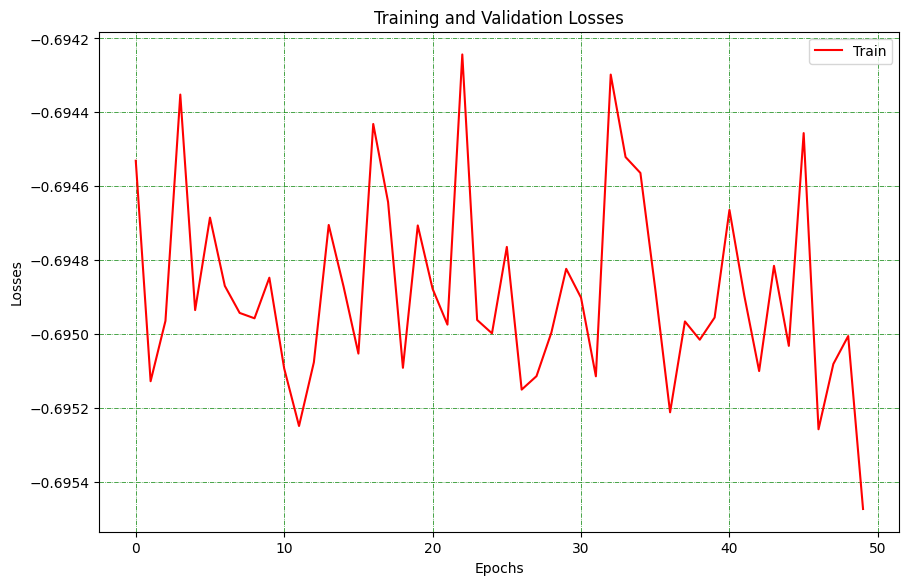

In [38]:
epochs = range(args['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(epochs, train_losses, color='r', label='Train', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

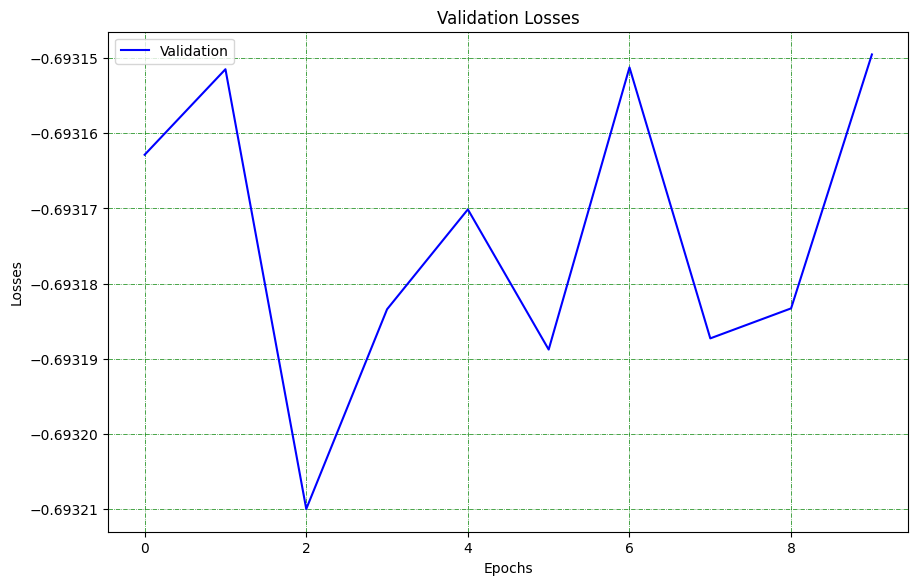

In [40]:
# the x axes is wrong, but ignore for now
epochs = range(args['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(range(args['num_epoch'] // args['eval_epoch']), val_losses, color='b', label='Validation', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Validation Losses')
plt.legend()
plt.show()


### Evaluate on test set

In [41]:
test_loss, test_recall, test_precision = evaluation(model, test_edge_index, test_edge_index_sparse, [train_edge_index, val_edge_index], args['topK'], args['lambda'])
print('Evaluation on test set: loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(test_loss, test_recall, test_precision))

Evaluation on test set: loss: -0.6932, recall: 0.0006, precision: 0.0001
